# **Initialisation**

In [ ]:
from tensorflow import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from keras.callbacks import CSVLogger
import random
import cv2
from sklearn.utils import shuffle
import skimage.measure

In [ ]:
!pip install pyyaml h5py

In [ ]:
(trainx, trainy), (testx, testy) = mnist.load_data()

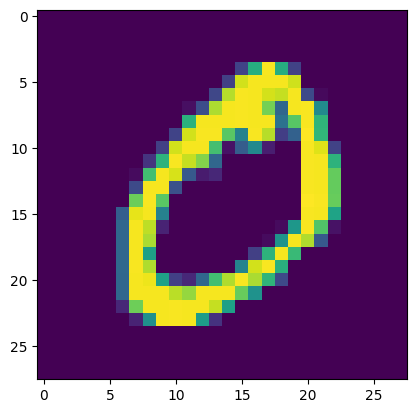

In [ ]:
plt.imshow(trainx[1])

In [ ]:
trainy[1]

0

# **Large CNNs**

## Model

In [ ]:
trainxmm = trainx/255.0
testxmm = testx/255.0

In [ ]:
# trainxmm = np.expand_dims(trainxmm, axis=3)
# testxmm = np.expand_dims(trainxmm, axis=3)

In [ ]:
# trainxmm.shape

**Wider layer**

In [ ]:
def metric(y_true,y_pred):
  # print(type(y_true))
  result = y_pred * tf.transpose(y_true)
  return tf.reduce_sum(result)/2*tf.shape(result)

In [ ]:
model = keras.Sequential([
    # keras.layers.MaxPooling2D((2,2),input_shape = (28,28,1)),
    # keras.layers.MaxPooling2D((2,2)),
    keras.layers.RandomRotation(0.5,input_shape = (14,14,1)),

    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    # keras.layers.Conv2D(filters = 32, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Conv2D(filters = 128, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.Conv2D(filters = 256, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation = 'relu'),
    # keras.layers.Dense(11, activation = 'relu'),
    # keras.layers.Dropout(0.05),
    keras.layers.Dense(11, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRot  (None, 14, 14, 1)         0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       37120     
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1000)              50177000  
                                                                 
 dense_1 (Dense)             (None, 11)                11011     
                                                        

In [ ]:
def add_f_train(trainy,n):
  trainy_new = np.zeros((trainy.shape[0],n+1))
  for i in range(trainy.shape[0]):
    trainy_new[i,trainy[i] + 1] = 1
    trainy_new[i,0] = 0

  return trainy_new

In [ ]:
def add_non_numbers(x, y):
  trainx_new = np.zeros((x.shape[0]*11//10, x.shape[1], x.shape[2]))
  trainy_new = np.zeros((y.shape[0]*11//10, y.shape[1]))

  trainx_new [:x.shape[0]] = x
  for i in range(x.shape[0]//10):
    trainx_new [x.shape[0]+i] = np.random.rand(x.shape[1],x.shape[2])/random.randint(1,100)

  trainy_new [:y.shape[0]] = y
  trainy_new [y.shape[0]:,0] = np.ones(y.shape[0]*1//10)

  return shuffle(trainx_new, trainy_new)

In [ ]:
def add_lines(x):
  a = random.randint(1,4)
  if a == 1:
    cv2.line(x,
          (0,random.randint(0,X.shape[1]-1)),
          (X.shape[2]-1,random.randint(0,X.shape[1]-1)),
          (1,1,1),
          random.randint(2,2))/255

  elif a == 2:
    cv2.line(x,
          (random.randint(0,X.shape[2]-1),0),
          (random.randint(0,X.shape[2]-1),X.shape[1]-1),
          (1,1,1),
          random.randint(2,2))/255

  elif a == 3:
    cv2.line(x,
          (0,random.randint(0,X.shape[1]-1)),
          (random.randint(0,X.shape[2]-1),X.shape[1]-1),
          (1,1,1),
          random.randint(2,2))/255

  else:
    cv2.line(x,
          (random.randint(0,X.shape[2]-1),0),
          (X.shape[2]-1, random.randint(0,X.shape[1]-1)),
          (1,1,1),
          random.randint(2,2))/255

In [ ]:
def reduce(xmm,n=2):
  x = np.zeros((xmm.shape[0], xmm.shape[1]//n, xmm.shape[2]//n))
  for i in range(xmm.shape[0]):
    x[i] = skimage.measure.block_reduce(xmm[i], (n,n), np.max)

  return x

In [ ]:
trainy_new = add_f_train(trainy,10)
testy_new = add_f_train(testy,10)

In [ ]:
trainy_new[1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
xmm = reduce(trainxmm, n=2)
xmm_val = reduce(testxmm, n=2)

In [ ]:
X,y = add_non_numbers(xmm, trainy_new)

In [ ]:
for i in range((X.shape[0])//2):
  add_lines(X[i])

In [ ]:
X,y = shuffle(X,y)

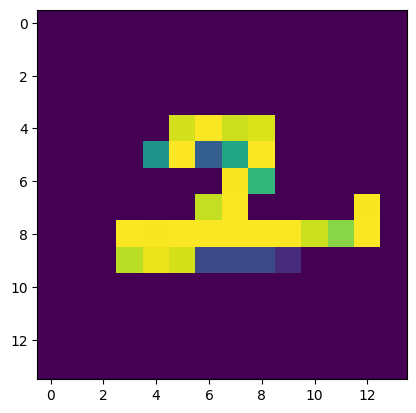

In [ ]:
plt.imshow(X[242])

In [ ]:
y[234]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

## Training

In [ ]:
from tqdm import tqdm

checkpoint_path = "training_1/val_loss.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

csv_logger = CSVLogger('training_log.csv', append=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 verbose=1)

# Train the model with the new callback
for i in tqdm(range(100)):


  X,y = add_non_numbers(xmm, trainy_new)

  for i in range((X.shape[0])//2):
    add_lines(X[i])

  X,y = shuffle(X,y)


  X_val,y_val = add_non_numbers(xmm_val, testy_new)

  for i in range((X_val.shape[0])//2):
    add_lines(X_val[i])

  X_val,y_val = shuffle(X_val,y_val)


  model.fit(X,
    y,
    epochs=1,
    batch_size = 1000,
    validation_data=(X_val, y_val),
    callbacks=[csv_logger])

  0%|          | 0/100 [00:00<?, ?it/s]

66/66 [==============================] - 12s 117ms/step - loss: 0.0878 - categorical_accuracy: 0.1033 - val_loss: 0.0828 - val_categorical_accuracy: 0.1705


  1%|          | 1/100 [00:22<36:47, 22.30s/it]

66/66 [==============================] - 8s 121ms/step - loss: 0.0628 - categorical_accuracy: 0.4317 - val_loss: 0.0425 - val_categorical_accuracy: 0.6732


  2%|▏         | 2/100 [00:31<23:32, 14.41s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0358 - categorical_accuracy: 0.7341 - val_loss: 0.0283 - val_categorical_accuracy: 0.7953


  3%|▎         | 3/100 [00:42<20:46, 12.85s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0277 - categorical_accuracy: 0.7968 - val_loss: 0.0232 - val_categorical_accuracy: 0.8344


  4%|▍         | 4/100 [00:50<17:55, 11.20s/it]

66/66 [==============================] - 8s 123ms/step - loss: 0.0239 - categorical_accuracy: 0.8262 - val_loss: 0.0204 - val_categorical_accuracy: 0.8535


  5%|▌         | 5/100 [01:02<17:47, 11.24s/it]

66/66 [==============================] - 8s 117ms/step - loss: 0.0213 - categorical_accuracy: 0.8460 - val_loss: 0.0191 - val_categorical_accuracy: 0.8679


  6%|▌         | 6/100 [01:10<16:11, 10.33s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0195 - categorical_accuracy: 0.8605 - val_loss: 0.0172 - val_categorical_accuracy: 0.8784


  7%|▋         | 7/100 [01:22<16:53, 10.90s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0179 - categorical_accuracy: 0.8723 - val_loss: 0.0154 - val_categorical_accuracy: 0.8926


  8%|▊         | 8/100 [01:31<15:29, 10.11s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0170 - categorical_accuracy: 0.8789 - val_loss: 0.0151 - val_categorical_accuracy: 0.8963


  9%|▉         | 9/100 [01:39<14:40,  9.68s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0158 - categorical_accuracy: 0.8893 - val_loss: 0.0149 - val_categorical_accuracy: 0.8960


 10%|█         | 10/100 [01:51<15:18, 10.21s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0152 - categorical_accuracy: 0.8935 - val_loss: 0.0143 - val_categorical_accuracy: 0.8986


 11%|█         | 11/100 [02:00<14:30,  9.78s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0147 - categorical_accuracy: 0.8975 - val_loss: 0.0139 - val_categorical_accuracy: 0.9026


 12%|█▏        | 12/100 [02:11<14:53, 10.16s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0139 - categorical_accuracy: 0.9026 - val_loss: 0.0134 - val_categorical_accuracy: 0.9052


 13%|█▎        | 13/100 [02:19<13:59,  9.65s/it]

66/66 [==============================] - 8s 121ms/step - loss: 0.0134 - categorical_accuracy: 0.9068 - val_loss: 0.0123 - val_categorical_accuracy: 0.9139


 14%|█▍        | 14/100 [02:28<13:26,  9.37s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0130 - categorical_accuracy: 0.9103 - val_loss: 0.0126 - val_categorical_accuracy: 0.9144


 15%|█▌        | 15/100 [02:39<14:04,  9.94s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0128 - categorical_accuracy: 0.9112 - val_loss: 0.0117 - val_categorical_accuracy: 0.9201


 16%|█▌        | 16/100 [02:50<14:30, 10.37s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0124 - categorical_accuracy: 0.9146 - val_loss: 0.0114 - val_categorical_accuracy: 0.9222


 17%|█▋        | 17/100 [02:59<13:40,  9.88s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0120 - categorical_accuracy: 0.9181 - val_loss: 0.0109 - val_categorical_accuracy: 0.9247


 18%|█▊        | 18/100 [03:10<13:57, 10.22s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0116 - categorical_accuracy: 0.9198 - val_loss: 0.0111 - val_categorical_accuracy: 0.9255


 19%|█▉        | 19/100 [03:21<14:07, 10.46s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0114 - categorical_accuracy: 0.9209 - val_loss: 0.0107 - val_categorical_accuracy: 0.9289


 20%|██        | 20/100 [03:30<13:08,  9.86s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0110 - categorical_accuracy: 0.9251 - val_loss: 0.0111 - val_categorical_accuracy: 0.9227


 21%|██        | 21/100 [03:41<13:26, 10.21s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0110 - categorical_accuracy: 0.9246 - val_loss: 0.0102 - val_categorical_accuracy: 0.9310


 22%|██▏       | 22/100 [03:49<12:41,  9.76s/it]

66/66 [==============================] - 8s 116ms/step - loss: 0.0107 - categorical_accuracy: 0.9272 - val_loss: 0.0107 - val_categorical_accuracy: 0.9291


 23%|██▎       | 23/100 [04:01<13:08, 10.24s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0106 - categorical_accuracy: 0.9276 - val_loss: 0.0104 - val_categorical_accuracy: 0.9295


 24%|██▍       | 24/100 [04:12<13:18, 10.51s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0104 - categorical_accuracy: 0.9283 - val_loss: 0.0102 - val_categorical_accuracy: 0.9313


 25%|██▌       | 25/100 [04:23<13:19, 10.65s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0102 - categorical_accuracy: 0.9308 - val_loss: 0.0095 - val_categorical_accuracy: 0.9358


 26%|██▌       | 26/100 [04:34<13:16, 10.76s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0100 - categorical_accuracy: 0.9323 - val_loss: 0.0099 - val_categorical_accuracy: 0.9315


 27%|██▋       | 27/100 [04:42<12:14, 10.06s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0100 - categorical_accuracy: 0.9330 - val_loss: 0.0091 - val_categorical_accuracy: 0.9401


 28%|██▊       | 28/100 [04:53<12:24, 10.34s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0098 - categorical_accuracy: 0.9338 - val_loss: 0.0100 - val_categorical_accuracy: 0.9333


 29%|██▉       | 29/100 [05:02<11:39,  9.86s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0096 - categorical_accuracy: 0.9345 - val_loss: 0.0094 - val_categorical_accuracy: 0.9355


 30%|███       | 30/100 [05:11<11:05,  9.51s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0096 - categorical_accuracy: 0.9342 - val_loss: 0.0093 - val_categorical_accuracy: 0.9356


 31%|███       | 31/100 [05:19<10:34,  9.19s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0095 - categorical_accuracy: 0.9355 - val_loss: 0.0099 - val_categorical_accuracy: 0.9340


 32%|███▏      | 32/100 [05:28<10:14,  9.03s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0094 - categorical_accuracy: 0.9364 - val_loss: 0.0095 - val_categorical_accuracy: 0.9358


 33%|███▎      | 33/100 [05:39<10:44,  9.63s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0092 - categorical_accuracy: 0.9375 - val_loss: 0.0093 - val_categorical_accuracy: 0.9384


 34%|███▍      | 34/100 [05:47<10:11,  9.27s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0091 - categorical_accuracy: 0.9380 - val_loss: 0.0089 - val_categorical_accuracy: 0.9405


 35%|███▌      | 35/100 [05:58<10:36,  9.79s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0091 - categorical_accuracy: 0.9388 - val_loss: 0.0082 - val_categorical_accuracy: 0.9428


 36%|███▌      | 36/100 [06:07<09:58,  9.36s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0089 - categorical_accuracy: 0.9390 - val_loss: 0.0088 - val_categorical_accuracy: 0.9397


 37%|███▋      | 37/100 [06:15<09:35,  9.14s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0089 - categorical_accuracy: 0.9402 - val_loss: 0.0087 - val_categorical_accuracy: 0.9415


 38%|███▊      | 38/100 [06:26<10:00,  9.69s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0088 - categorical_accuracy: 0.9408 - val_loss: 0.0085 - val_categorical_accuracy: 0.9429


 39%|███▉      | 39/100 [06:35<09:27,  9.30s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0087 - categorical_accuracy: 0.9406 - val_loss: 0.0089 - val_categorical_accuracy: 0.9397


 40%|████      | 40/100 [06:43<09:01,  9.02s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0086 - categorical_accuracy: 0.9419 - val_loss: 0.0091 - val_categorical_accuracy: 0.9364


 41%|████      | 41/100 [06:51<08:40,  8.82s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0085 - categorical_accuracy: 0.9435 - val_loss: 0.0083 - val_categorical_accuracy: 0.9434


 42%|████▏     | 42/100 [07:00<08:23,  8.68s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0084 - categorical_accuracy: 0.9435 - val_loss: 0.0088 - val_categorical_accuracy: 0.9412


 43%|████▎     | 43/100 [07:11<09:00,  9.48s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0085 - categorical_accuracy: 0.9423 - val_loss: 0.0085 - val_categorical_accuracy: 0.9427


 44%|████▍     | 44/100 [07:22<09:17,  9.96s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0083 - categorical_accuracy: 0.9441 - val_loss: 0.0082 - val_categorical_accuracy: 0.9454


 45%|████▌     | 45/100 [07:33<09:24, 10.27s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0083 - categorical_accuracy: 0.9445 - val_loss: 0.0082 - val_categorical_accuracy: 0.9467


 46%|████▌     | 46/100 [07:42<08:43,  9.70s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0083 - categorical_accuracy: 0.9432 - val_loss: 0.0082 - val_categorical_accuracy: 0.9437


 47%|████▋     | 47/100 [07:50<08:13,  9.30s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0081 - categorical_accuracy: 0.9459 - val_loss: 0.0086 - val_categorical_accuracy: 0.9406


 48%|████▊     | 48/100 [08:01<08:31,  9.83s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0082 - categorical_accuracy: 0.9455 - val_loss: 0.0078 - val_categorical_accuracy: 0.9485


 49%|████▉     | 49/100 [08:09<08:00,  9.42s/it]

66/66 [==============================] - 8s 120ms/step - loss: 0.0079 - categorical_accuracy: 0.9475 - val_loss: 0.0082 - val_categorical_accuracy: 0.9440


 50%|█████     | 50/100 [08:21<08:15,  9.90s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0081 - categorical_accuracy: 0.9461 - val_loss: 0.0081 - val_categorical_accuracy: 0.9465


 51%|█████     | 51/100 [08:32<08:21, 10.24s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0078 - categorical_accuracy: 0.9482 - val_loss: 0.0078 - val_categorical_accuracy: 0.9486


 52%|█████▏    | 52/100 [08:40<07:45,  9.70s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0078 - categorical_accuracy: 0.9474 - val_loss: 0.0077 - val_categorical_accuracy: 0.9468


 53%|█████▎    | 53/100 [08:49<07:21,  9.39s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0078 - categorical_accuracy: 0.9471 - val_loss: 0.0076 - val_categorical_accuracy: 0.9480


 54%|█████▍    | 54/100 [09:00<07:37,  9.94s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0077 - categorical_accuracy: 0.9485 - val_loss: 0.0082 - val_categorical_accuracy: 0.9426


 55%|█████▌    | 55/100 [09:09<07:13,  9.64s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0076 - categorical_accuracy: 0.9495 - val_loss: 0.0080 - val_categorical_accuracy: 0.9463


 56%|█████▌    | 56/100 [09:17<06:47,  9.27s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0077 - categorical_accuracy: 0.9489 - val_loss: 0.0080 - val_categorical_accuracy: 0.9453


 57%|█████▋    | 57/100 [09:26<06:26,  9.00s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0075 - categorical_accuracy: 0.9495 - val_loss: 0.0084 - val_categorical_accuracy: 0.9435


 58%|█████▊    | 58/100 [09:37<06:44,  9.62s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0076 - categorical_accuracy: 0.9494 - val_loss: 0.0077 - val_categorical_accuracy: 0.9489


 59%|█████▉    | 59/100 [09:45<06:18,  9.24s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0075 - categorical_accuracy: 0.9499 - val_loss: 0.0075 - val_categorical_accuracy: 0.9510


 60%|██████    | 60/100 [09:56<06:31,  9.78s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0073 - categorical_accuracy: 0.9506 - val_loss: 0.0080 - val_categorical_accuracy: 0.9455


 61%|██████    | 61/100 [10:07<06:36, 10.16s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0073 - categorical_accuracy: 0.9514 - val_loss: 0.0081 - val_categorical_accuracy: 0.9445


 62%|██████▏   | 62/100 [10:15<06:05,  9.61s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0072 - categorical_accuracy: 0.9520 - val_loss: 0.0075 - val_categorical_accuracy: 0.9508


 63%|██████▎   | 63/100 [10:26<06:10, 10.03s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0073 - categorical_accuracy: 0.9514 - val_loss: 0.0080 - val_categorical_accuracy: 0.9468


 64%|██████▍   | 64/100 [10:37<06:11, 10.32s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0070 - categorical_accuracy: 0.9540 - val_loss: 0.0079 - val_categorical_accuracy: 0.9490


 65%|██████▌   | 65/100 [10:46<05:43,  9.81s/it]

66/66 [==============================] - 7s 114ms/step - loss: 0.0072 - categorical_accuracy: 0.9519 - val_loss: 0.0079 - val_categorical_accuracy: 0.9468


 66%|██████▌   | 66/100 [10:57<05:49, 10.29s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0072 - categorical_accuracy: 0.9506 - val_loss: 0.0074 - val_categorical_accuracy: 0.9517


 67%|██████▋   | 67/100 [11:09<05:50, 10.62s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0071 - categorical_accuracy: 0.9534 - val_loss: 0.0074 - val_categorical_accuracy: 0.9516


 68%|██████▊   | 68/100 [11:17<05:19,  9.98s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0069 - categorical_accuracy: 0.9543 - val_loss: 0.0073 - val_categorical_accuracy: 0.9494


 69%|██████▉   | 69/100 [11:26<04:56,  9.57s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0070 - categorical_accuracy: 0.9542 - val_loss: 0.0071 - val_categorical_accuracy: 0.9533


 70%|███████   | 70/100 [11:34<04:36,  9.22s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0070 - categorical_accuracy: 0.9530 - val_loss: 0.0072 - val_categorical_accuracy: 0.9515


 71%|███████   | 71/100 [11:46<04:46,  9.87s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0069 - categorical_accuracy: 0.9543 - val_loss: 0.0073 - val_categorical_accuracy: 0.9506


 72%|███████▏  | 72/100 [11:54<04:26,  9.51s/it]

66/66 [==============================] - 7s 114ms/step - loss: 0.0070 - categorical_accuracy: 0.9532 - val_loss: 0.0077 - val_categorical_accuracy: 0.9491


 73%|███████▎  | 73/100 [12:05<04:28,  9.96s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0069 - categorical_accuracy: 0.9542 - val_loss: 0.0072 - val_categorical_accuracy: 0.9513


 74%|███████▍  | 74/100 [12:14<04:08,  9.55s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0066 - categorical_accuracy: 0.9562 - val_loss: 0.0067 - val_categorical_accuracy: 0.9558


 75%|███████▌  | 75/100 [12:25<04:09,  9.99s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0067 - categorical_accuracy: 0.9556 - val_loss: 0.0072 - val_categorical_accuracy: 0.9534


 76%|███████▌  | 76/100 [12:36<04:07, 10.31s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0069 - categorical_accuracy: 0.9544 - val_loss: 0.0070 - val_categorical_accuracy: 0.9526


 77%|███████▋  | 77/100 [12:47<04:01, 10.52s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0069 - categorical_accuracy: 0.9541 - val_loss: 0.0072 - val_categorical_accuracy: 0.9520


 78%|███████▊  | 78/100 [12:58<03:55, 10.68s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0067 - categorical_accuracy: 0.9553 - val_loss: 0.0072 - val_categorical_accuracy: 0.9511


 79%|███████▉  | 79/100 [13:09<03:46, 10.77s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0068 - categorical_accuracy: 0.9551 - val_loss: 0.0073 - val_categorical_accuracy: 0.9537


 80%|████████  | 80/100 [13:17<03:20, 10.05s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0067 - categorical_accuracy: 0.9560 - val_loss: 0.0070 - val_categorical_accuracy: 0.9532


 81%|████████  | 81/100 [13:26<03:01,  9.53s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0066 - categorical_accuracy: 0.9557 - val_loss: 0.0068 - val_categorical_accuracy: 0.9549


 82%|████████▏ | 82/100 [13:37<03:00, 10.00s/it]

66/66 [==============================] - 8s 113ms/step - loss: 0.0065 - categorical_accuracy: 0.9567 - val_loss: 0.0070 - val_categorical_accuracy: 0.9547


 83%|████████▎ | 83/100 [13:45<02:41,  9.50s/it]

66/66 [==============================] - 8s 118ms/step - loss: 0.0066 - categorical_accuracy: 0.9564 - val_loss: 0.0071 - val_categorical_accuracy: 0.9539


 84%|████████▍ | 84/100 [13:54<02:27,  9.23s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0065 - categorical_accuracy: 0.9577 - val_loss: 0.0071 - val_categorical_accuracy: 0.9547


 85%|████████▌ | 85/100 [14:03<02:16,  9.07s/it]

66/66 [==============================] - 7s 114ms/step - loss: 0.0066 - categorical_accuracy: 0.9568 - val_loss: 0.0066 - val_categorical_accuracy: 0.9579


 86%|████████▌ | 86/100 [14:11<02:03,  8.83s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0065 - categorical_accuracy: 0.9577 - val_loss: 0.0065 - val_categorical_accuracy: 0.9575


 87%|████████▋ | 87/100 [14:22<02:03,  9.49s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0064 - categorical_accuracy: 0.9575 - val_loss: 0.0066 - val_categorical_accuracy: 0.9560


 88%|████████▊ | 88/100 [14:33<01:59,  9.96s/it]

66/66 [==============================] - 8s 113ms/step - loss: 0.0065 - categorical_accuracy: 0.9567 - val_loss: 0.0070 - val_categorical_accuracy: 0.9530


 89%|████████▉ | 89/100 [14:44<01:53, 10.29s/it]

66/66 [==============================] - 8s 113ms/step - loss: 0.0064 - categorical_accuracy: 0.9576 - val_loss: 0.0071 - val_categorical_accuracy: 0.9532


 90%|█████████ | 90/100 [14:52<01:37,  9.71s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0064 - categorical_accuracy: 0.9580 - val_loss: 0.0067 - val_categorical_accuracy: 0.9562


 91%|█████████ | 91/100 [15:01<01:24,  9.35s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0063 - categorical_accuracy: 0.9582 - val_loss: 0.0068 - val_categorical_accuracy: 0.9547


 92%|█████████▏| 92/100 [15:12<01:18,  9.87s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0063 - categorical_accuracy: 0.9578 - val_loss: 0.0068 - val_categorical_accuracy: 0.9569


 93%|█████████▎| 93/100 [15:23<01:11, 10.22s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0063 - categorical_accuracy: 0.9585 - val_loss: 0.0067 - val_categorical_accuracy: 0.9564


 94%|█████████▍| 94/100 [15:34<01:02, 10.46s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0063 - categorical_accuracy: 0.9586 - val_loss: 0.0065 - val_categorical_accuracy: 0.9571


 95%|█████████▌| 95/100 [15:42<00:49,  9.83s/it]

66/66 [==============================] - 8s 119ms/step - loss: 0.0063 - categorical_accuracy: 0.9581 - val_loss: 0.0069 - val_categorical_accuracy: 0.9548


 96%|█████████▌| 96/100 [15:51<00:38,  9.53s/it]

66/66 [==============================] - 8s 115ms/step - loss: 0.0062 - categorical_accuracy: 0.9591 - val_loss: 0.0068 - val_categorical_accuracy: 0.9538


 97%|█████████▋| 97/100 [15:59<00:27,  9.16s/it]

66/66 [==============================] - 8s 114ms/step - loss: 0.0063 - categorical_accuracy: 0.9586 - val_loss: 0.0065 - val_categorical_accuracy: 0.9592


 98%|█████████▊| 98/100 [16:08<00:17,  8.91s/it]

66/66 [==============================] - 7s 114ms/step - loss: 0.0062 - categorical_accuracy: 0.9592 - val_loss: 0.0067 - val_categorical_accuracy: 0.9542


 99%|█████████▉| 99/100 [16:16<00:08,  8.72s/it]

66/66 [==============================] - 7s 114ms/step - loss: 0.0062 - categorical_accuracy: 0.9592 - val_loss: 0.0067 - val_categorical_accuracy: 0.9562


100%|██████████| 100/100 [16:24<00:00,  9.85s/it]


In [ ]:
logs = pd.read_csv('training_log.csv')

In [ ]:
logs['val_categorical_accuracy'].max()

0.9591818451881408

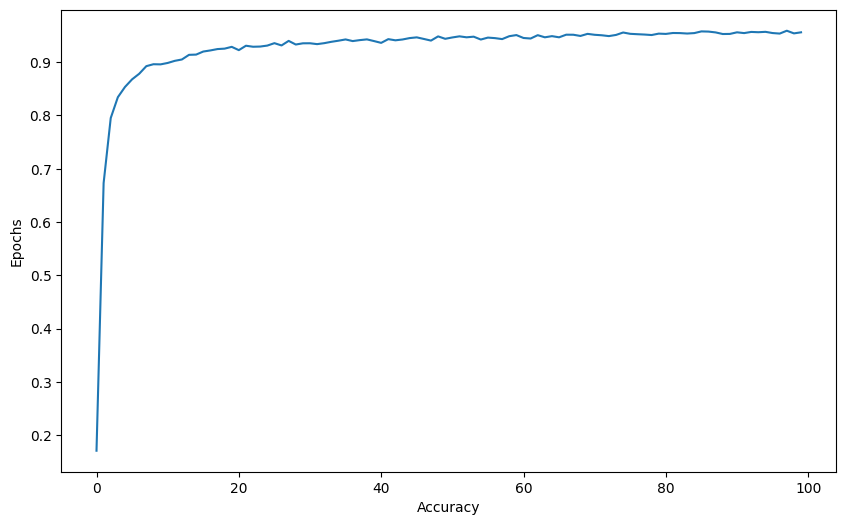

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(logs['val_categorical_accuracy'])
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

In [ ]:
X_val,y_val = add_non_numbers(xmm_val, testy_new)

for i in range((X_val.shape[0])//2):
  add_lines(X_val[i])

X_val,y_val = shuffle(X_val,y_val)

In [ ]:
model.evaluate(X_val, y_val)

344/344 [==============================] - 2s 4ms/step - loss: 0.0067 - categorical_accuracy: 0.9550


[0.006697875447571278, 0.9549999833106995]

In [ ]:
prediction = model.predict(X_val)

344/344 [==============================] - 1s 2ms/step


In [ ]:
y_val

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

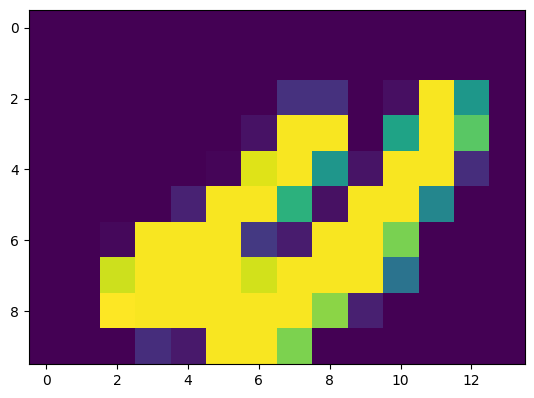

In [ ]:
plt.imshow(X_val[3][:10])

In [ ]:
X_val[3]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.14117647, 0.14117647, 0.        ,
        0.03921569, 0.99215686, 0.52941176, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.04705882, 0.99215686, 0.99215686, 0.        ,
        0.58039216, 0.99215686, 0.74509804, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01176471, 0.95294118, 0.99215686, 0.5254902 , 0.05098039,
        0.99215686, 0.99215686, 0.12941176, 0.        ],
       [0.        , 0.        , 0. 

In [ ]:
y_val[3]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [ ]:
prediction[3]

array([2.2143011e-08, 6.2879772e-06, 5.7368097e-06, 8.7567780e-05,
       4.1546826e-08, 9.9992323e-01, 1.5332874e-07, 1.2010207e-06,
       2.2691665e-06, 6.1429627e-02, 5.3843352e-09], dtype=float32)

In [ ]:
y_pred = np.array([np.argmax(i) for i in prediction])

In [ ]:
y_true = np.array([np.argmax(i) for i in y_val])

In [ ]:
y_true

array([10,  0,  0, ..., 10, 10,  4])

In [ ]:
y_pred

array([10,  0,  0, ..., 10, 10,  4])

In [ ]:
np.sum((y_true == y_pred).astype(int))/y_true.shape[0]

0.955

In [ ]:
cnf_mat = tf.math.confusion_matrix(labels = y_true, predictions = y_pred)
cnf_mat

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[1000,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  956,    0,    4,    1,    2,    2,    8,    1,    3,    3],
       [   0,    1, 1120,    1,    0,    2,    1,    1,    2,    6,    1],
       [   0,    4,    4,  990,    6,    4,    1,    0,    9,   13,    1],
       [   0,    1,    1,    8,  958,    1,   11,    3,    7,   17,    3],
       [   0,    0,    2,    2,    1,  933,    5,    3,   17,    4,   15],
       [   0,    2,    3,    0,   18,    4,  838,   13,    3,    6,    5],
       [   0,    5,    1,    4,    2,    6,    5,  911,    7,    4,   13],
       [   0,    0,    5,   10,    5,   14,    4,    9,  963,    0,   18],
       [   0,    4,    1,   12,    9,    6,    8,    5,    3,  923,    3],
       [   0,    3,    4,    1,    3,   21,   13,   31,   17,    3,  913]],
      dtype=int32)>

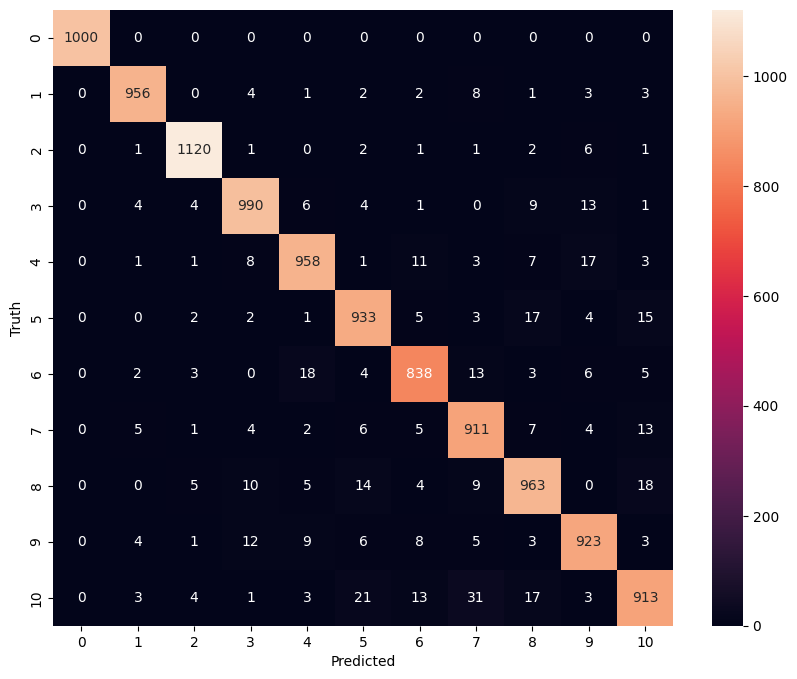

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(cnf_mat, annot= True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
y_true_pr = np.zeros(y_true.shape)
y_true_pr[y_true != 0] = 1

y_pred_pr = np.zeros(y_pred.shape)
y_pred_pr[y_pred != 0] = 1

In [ ]:
np.sum((y_true_pr == y_pred_pr).astype(int))/y_true_pr.shape[0]

1.0

In [ ]:
model.save('number_detection.keras')

In [ ]:
# Save the weights
model.save_weights('./checkpoints/Tata_Steel_Model')

In [ ]:
new_model = keras.Sequential([
    # keras.layers.MaxPooling2D((2,2),input_shape = (28,28,1)),
    # keras.layers.MaxPooling2D((2,2)),
    keras.layers.RandomRotation(0.5,input_shape = (14,14,1)),

    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    # keras.layers.Conv2D(filters = 32, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    # keras.layers.MaxPooling2D((2,2)),
    # keras.layers.Conv2D(filters = 128, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.Conv2D(filters = 256, padding = 'same', kernel_size = (3,3), activation = 'relu'),

    keras.layers.Flatten(),
    keras.layers.Dense(1000, activation = 'relu'),
    # keras.layers.Dense(11, activation = 'relu'),
    # keras.layers.Dropout(0.05),
    keras.layers.Dense(11, activation = 'sigmoid')
])

new_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [keras.metrics.CategoricalAccuracy()])

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomR  (None, 14, 14, 1)         0         
 otation)                                                        
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)       37120     
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 1000)              50177000  
                                                                 
 dense_3 (Dense)             (None, 11)                11011     
                                                      

In [ ]:
# Restore the weights
new_model.load_weights('./checkpoints/Tata_Steel_Model')

In [ ]:
new_model.evaluate(X_val, y_val)

344/344 [==============================] - 1s 3ms/step - loss: 0.0067 - categorical_accuracy: 0.9550


[0.006697875447571278, 0.9549999833106995]

## Large Network

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(filters = 16, padding = 'same', kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1)),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Conv2D(filters = 64, padding = 'same', kernel_size = (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D((2,2)),

    keras.layers.Flatten(),
    keras.layers.Dense(3136, activation = 'relu'),
    keras.layers.Dense(196, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

In [ ]:
checkpoint_path = "training_1/val_loss.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

csv_logger = CSVLogger('training_log2.csv', append=True)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_loss',
                                                 verbose=1)

# Train the model with the new callback
model.fit(trainxmm,
          trainy,
          epochs=100,
          batch_size = 1000,
          validation_data=(testxmm, testy),
          callbacks=[csv_logger])

In [ ]:
logs2 = pd.read_csv('training_log2.csv')

In [ ]:
logs2['val_accuracy'].max()

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(logs['val_accuracy'], color='blue')
plt.plot(logs2['val_accuracy'], color='orange')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

In [ ]:
model.evaluate(testxmm, testy)